[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/porterjenkins/byu-cs474/blob/master/lab5_generalization_regularization.ipynb)

# Lab 5: Overfitting, Generalization, and Regularization

---

## Objectives






*   Understand how to accurately measure generalization performance of deep networks
*   Gain intuition into the bias-variance trade-off and the double descent phenomenon
*   Investigate properties of high dimensional spaces and better understand the "curse of dimensionality"

---

## Deliverable



You will turn in a completed version of notebook to Canvas/Learning Suite.  In various places you will see the words "TO DO". Follow the instructions at these places and write code to complete the instructions

---

## Notes


You will need a GPU instance for this lab.

Students can sign up for a free Colab Pro subscription. This is recommended if you do not have your own GPU.

---

# Q1) Understanding Generalization

In this question, we will use the [MNIST1D dataset](https://github.com/greydanus/mnist1d) to reproduce Figure 8.2 from Prince.

In [1]:
# Run this if you're in Colab to install MNIST 1D repository
%pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-skprzbiz
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-skprzbiz
  Resolved https://github.com/greydanus/mnist1d to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post16-py3-none-any.whl size=14664 sha256=e35549af9bd74318076516ddb924ca8272206b0f097d2c9f4f6ac41c0b6251ec
  Stored in directory: /tmp/pip-ephem-wheel-cache-rp6vw2si/wheels/18/40/b6/29381fee9b4c80fdbc304d52bb065a7286bbcca5ca2b8737c0
Successfully built mnist1d


In [2]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

Let's generate a training and test dataset using the MNIST1D code. The dataset gets saved as a .pkl file so it doesn't have to be regenerated each time.

In [3]:
!mkdir ./sample_data

args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./sample_data/mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

mkdir: cannot create directory ‘./sample_data’: File exists
Did or could not load data from ./sample_data/mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [4]:
D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions

---

## Part 1.a)

**TODO:** Define a PyTorch model with two hidden layers of size 100 And ReLU activations between them

In [7]:
# Your code here (see Figure 7.8 of book for help)
model = nn.Sequential(
    nn.Linear(D_i, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_o),
)

**TODO:** Initialize the parameters with He initialization

In [8]:
def weights_init(layer_in):
    # TODO: Replace this line (see figure 7.8 of Prince for help)
    if isinstance(layer_in, nn.Linear):
        nn.init.kaiming_normal_(layer_in.weight)
        layer_in.bias.data.fill_(0.0)

In [9]:
# Call the function you just defined
model.apply(weights_init)

Sequential(
  (0): Linear(in_features=40, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=10, bias=True)
)

In [10]:
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('long'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('long'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)


Sequential(
  (0): Linear(in_features=40, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=10, bias=True)
)

In [11]:
def train_model(model, data_loader, n_epoch=50):

    # Initialize model weights
    model.apply(weights_init)

    # store the loss and the % correct at each epoch
    losses_train = np.zeros((n_epoch))
    errors_train = np.zeros((n_epoch))
    losses_test = np.zeros((n_epoch))
    errors_test = np.zeros((n_epoch))

    # choose cross entropy loss function (equation 5.24)
    loss_function = torch.nn.CrossEntropyLoss()
    # construct SGD optimizer and initialize learning rate and momentum
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
    # object that decreases learning rate by half every 10 epochs
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)


    for epoch in range(n_epoch):
      # loop over batches
      for i, batch in enumerate(data_loader):
        # retrieve inputs and labels for this batch
        x_batch, y_batch = batch
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass -- calculate model output
        pred = model(x_batch)
        # compute the loss
        loss = loss_function(pred, y_batch)
        # backward pass
        loss.backward()
        # SGD update
        optimizer.step()

      # Run whole dataset to get statistics -- normally wouldn't do this
      pred_train = model(x_train)
      pred_test = model(x_test)
      _, predicted_train_class = torch.max(pred_train.data, 1)
      _, predicted_test_class = torch.max(pred_test.data, 1)
      errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
      errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
      losses_train[epoch] = loss_function(pred_train, y_train).item()
      losses_test[epoch]= loss_function(pred_test, y_test).item()
      print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

      # tell scheduler to consider updating learning rate
      scheduler.step()

    return errors_train, errors_test, losses_train, losses_test

In [12]:
def plot_results(errors_train, errors_test, losses_train, losses_test, n_epoch=50):

    # Plot the results
    fig, ax = plt.subplots()
    ax.plot(errors_train,'r-',label='train')
    ax.plot(errors_test,'b-',label='test')
    ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
    ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
    ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
    ax.legend()
    plt.show()

    # Plot the results
    fig, ax = plt.subplots()
    ax.plot(losses_train,'r-',label='train')
    ax.plot(losses_test,'b-',label='test')
    ax.set_xlim(0,n_epoch)
    ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
    ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
    ax.legend()
    plt.show()

**TODO:** Train your model for 50 epochs

In [13]:
train_errors, test_errors, train_losses, test_losses = train_model(model, data_loader, 50)

Epoch     0, train loss 1.565295, train error 60.67,  test loss 1.659634, test error 66.80
Epoch     1, train loss 1.382830, train error 52.92,  test loss 1.529680, test error 61.90
Epoch     2, train loss 1.188108, train error 43.15,  test loss 1.351146, test error 54.60
Epoch     3, train loss 1.023829, train error 37.55,  test loss 1.225132, test error 48.80
Epoch     4, train loss 0.885884, train error 31.00,  test loss 1.144164, test error 45.70
Epoch     5, train loss 0.807920, train error 28.93,  test loss 1.125398, test error 44.10
Epoch     6, train loss 0.721787, train error 24.55,  test loss 1.083131, test error 42.30
Epoch     7, train loss 0.635024, train error 22.12,  test loss 1.066906, test error 41.00
Epoch     8, train loss 0.613093, train error 21.50,  test loss 1.104589, test error 40.40
Epoch     9, train loss 0.522664, train error 17.90,  test loss 1.076811, test error 39.70
Epoch    10, train loss 0.464073, train error 15.28,  test loss 1.049087, test error 39.40

**TODO**: Plot the resulting quantities:
- Train errors
- Test errors
- Train losses
- Test losses

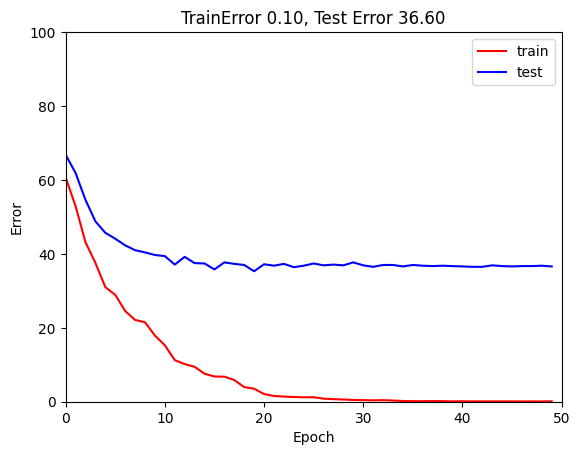

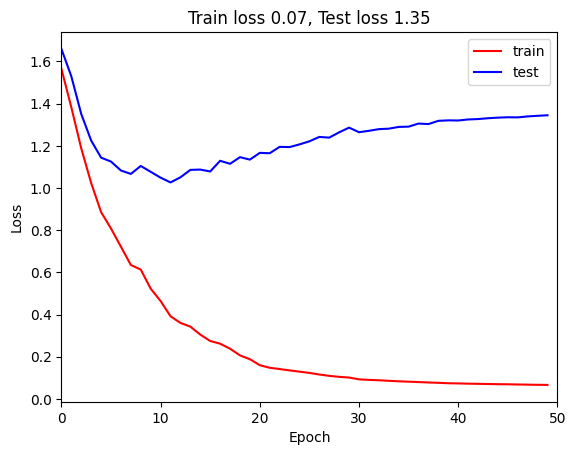

In [14]:
plot_results(train_errors, test_errors, train_losses, test_losses, n_epoch=50)

---

## Part 1.b)

Now let's increase the capacity of our model to have five hidden layers and re-run our experiment. Pay attention to what happens to the train and test curves.

**TODO:**
Define a model with five hidden layers of size 100
and ReLU activations between them

In [19]:
# Your code here:
model = nn.Sequential(
    nn.Linear(D_i, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_o),
)
model.apply(weights_init)

Sequential(
  (0): Linear(in_features=40, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Linear(in_features=100, out_features=100, bias=True)
  (9): ReLU()
  (10): Linear(in_features=100, out_features=10, bias=True)
)

**TODO**: Train the model using the same code as above

In [20]:
# Your code here
train_errors, test_errors, train_losses, test_losses = train_model(model, data_loader, 50)

Epoch     0, train loss 1.763769, train error 72.60,  test loss 1.801587, test error 74.00
Epoch     1, train loss 1.439214, train error 56.47,  test loss 1.547996, test error 63.20
Epoch     2, train loss 1.194155, train error 46.28,  test loss 1.370321, test error 57.10
Epoch     3, train loss 1.127217, train error 43.00,  test loss 1.352518, test error 53.10
Epoch     4, train loss 1.092949, train error 42.72,  test loss 1.489254, test error 57.30
Epoch     5, train loss 0.931741, train error 35.10,  test loss 1.273277, test error 51.90
Epoch     6, train loss 0.836669, train error 32.88,  test loss 1.244148, test error 46.60
Epoch     7, train loss 0.631673, train error 23.20,  test loss 1.125248, test error 41.30
Epoch     8, train loss 0.575616, train error 21.10,  test loss 1.194167, test error 41.90
Epoch     9, train loss 0.509023, train error 18.60,  test loss 1.161497, test error 41.50
Epoch    10, train loss 0.335055, train error 11.32,  test loss 1.136672, test error 36.00

**TODO**: Plot the results using the same code as above

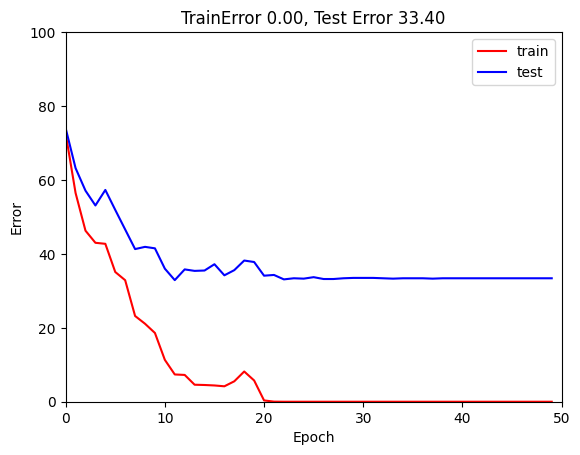

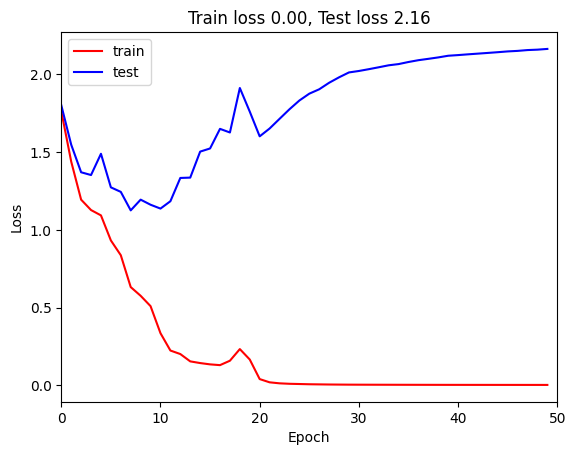

In [21]:
# Your code here
plot_results(train_errors, test_errors, train_losses, test_losses, n_epoch=50)

---

## Part 1.c)

Let's run one last experiment, this time with a simple linear model with **NO** hidden layers. In this case we will decrease the capacity of the model. Again, pay attention to what happens to the train and test curves.

**TODO:** Define a model with no hidden layers. This model should just be a linear layer that maps from the input dimension, `D_i` to the output dimension, `D_o`

In [22]:
# Your code here
model = nn.Sequential(
    nn.Linear(D_i, D_o),
)
model.apply(weights_init)

Sequential(
  (0): Linear(in_features=40, out_features=10, bias=True)
)

**TODO**: Train the model using the same code as above


In [23]:
# Your code here
train_errors, test_errors, train_losses, test_losses = train_model(model, data_loader, 50)

Epoch     0, train loss 1.788447, train error 70.68,  test loss 1.808151, test error 72.80
Epoch     1, train loss 1.696108, train error 68.03,  test loss 1.719670, test error 68.70
Epoch     2, train loss 1.667413, train error 66.65,  test loss 1.726636, test error 70.50
Epoch     3, train loss 1.645772, train error 65.85,  test loss 1.693027, test error 68.60
Epoch     4, train loss 1.635334, train error 64.93,  test loss 1.690082, test error 68.30
Epoch     5, train loss 1.633012, train error 65.68,  test loss 1.687882, test error 68.70
Epoch     6, train loss 1.634861, train error 64.75,  test loss 1.701760, test error 68.70
Epoch     7, train loss 1.614690, train error 64.05,  test loss 1.677374, test error 69.80
Epoch     8, train loss 1.615001, train error 64.93,  test loss 1.680688, test error 67.80
Epoch     9, train loss 1.612772, train error 63.65,  test loss 1.672530, test error 68.20
Epoch    10, train loss 1.606246, train error 64.32,  test loss 1.677016, test error 69.20

**TODO**: Plot the results using the same code as above

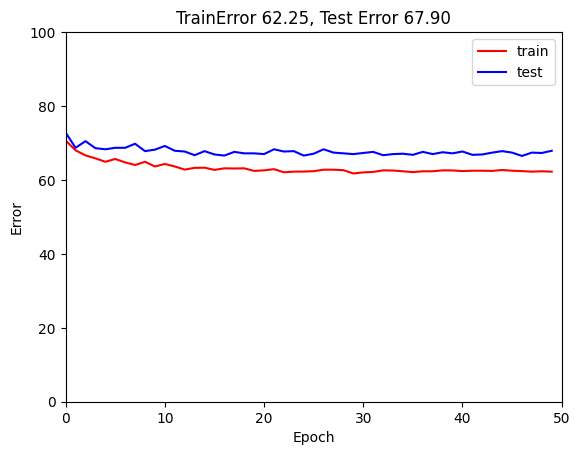

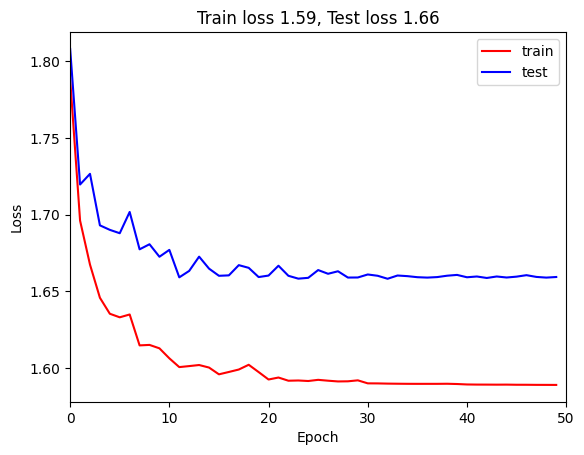

In [24]:
# Your code here
plot_results(train_errors, test_errors, train_losses, test_losses, n_epoch=50)

---

## Part 1.d: Discussion


What did you observe as you changed the model capacity in your experiments? What are some measures you might include to improve generalization of your models?

In [ ]:
# Your response here
"""
Models with a high number of layers can reach very low loss in a realitvily low number of epochs.
However, the loss and accuracy of the test data quickly diverges from the training data.
This indicates that the model is overfit to the data. It has essentially memorized data in the training set.
The best way to correct this would be to have a larger training set. This is often not possible or practical,
so another thing that can be done to avoid overfitting is to use a simpler model archetecture. This makes it
more difficult for the model to memorize the training data and more likely to match general trends.
"""

---

# Q2:  Bias-variance Trade-off


In this problem, we will investigate the bias-variance trade-off and reproduce the curves seen in Figure 8.8 in Prince.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Let's specify the true function that we are trying to estimate, defined on [0,1]

In [ ]:
def true_function(x):
    y = np.exp(np.sin(x*(2*3.1413)))
    return y

Now let's generate some data point and add bit of noise to the labels

In [ ]:
def generate_data(n_data, sigma_y=0.3):
    # Generate x values quasi uniformly
    x = np.ones(n_data)
    for i in range(n_data):
        x[i] = np.random.uniform(i/n_data, (i+1)/n_data, 1)

    # y value from running through function and adding noise
    y = np.ones(n_data)
    for i in range(n_data):
        y[i] = true_function(x[i])
        y[i] += np.random.normal(0, sigma_y, 1)
    return x,y


Let's draw the fitted function, together with uncertainty used to generate points


In [ ]:
def plot_function(x_func, y_func, x_data=None,y_data=None, x_model = None, y_model =None, sigma_func = None, sigma_model=None):

    fig,ax = plt.subplots()
    ax.plot(x_func, y_func, 'k-')
    if sigma_func is not None:
      ax.fill_between(x_func, y_func-2*sigma_func, y_func+2*sigma_func, color='lightgray')

    if x_data is not None:
        ax.plot(x_data, y_data, 'o', color='#d18362')

    if x_model is not None:
        ax.plot(x_model, y_model, '-', color='#7fe7de')

    if sigma_model is not None:
      ax.fill_between(x_model, y_model-2*sigma_model, y_model+2*sigma_model, color='lightgray')

    ax.set_xlim(0,1)
    ax.set_xlabel('Input, x')
    ax.set_ylabel('Output, y')
    plt.show()
    plt.show()

Sample from the true function (no noise):

In [ ]:
x_func = np.linspace(0, 1.0, 100)
y_func = true_function(x_func);

Generate some training data (with noise):

In [ ]:
np.random.seed(1)
sigma_func = 0.3
n_data = 15
x_data,y_data = generate_data(n_data, sigma_func)

Plot the data with the functions defined above

In [ ]:
plot_function(x_func, y_func, x_data, y_data, sigma_func=sigma_func)

In [ ]:
# Define model -- beta is a scalar and omega has size n_hidden,1
def network(x, beta, omega):
    # Retrieve number of hidden units
    n_hidden = omega.shape[0]

    y = np.zeros_like(x)
    for c_hidden in range(n_hidden):
        # Evaluate activations based on shifted lines (figure 8.4b-d)
        line_vals =  x  - c_hidden/n_hidden
        h =  line_vals * (line_vals > 0)
        # Weight activations by omega parameters and sum
        y = y + omega[c_hidden] * h
    # Add bias, beta
    y = y + beta

    return y

In [ ]:
# This fits the n_hidden+1 parameters (see fig 8.4a) in closed form.
# If you have studied linear algebra, then you will know it is a least
# squares solution of the form (A^TA)^-1A^Tb.  If you don't recognize that,
# then just take it on trust that this gives you the best possible solution.
def fit_model_closed_form(x,y,n_hidden):
  n_data = len(x)
  A = np.ones((n_data, n_hidden+1))
  for i in range(n_data):
      for j in range(1,n_hidden+1):
          A[i,j] = x[i]-(j-1)/n_hidden
          if A[i,j] < 0:
              A[i,j] = 0;

  beta_omega = np.linalg.lstsq(A, y, rcond=None)[0]

  beta = beta_omega[0]
  omega = beta_omega[1:]

  return beta, omega

In [ ]:
# Closed form solution
beta, omega = fit_model_closed_form(x_data,y_data,n_hidden=3)

# Get prediction for model across graph range
x_model = np.linspace(0,1,100);
y_model = network(x_model, beta, omega)

# Draw the function and the model
plot_function(x_func, y_func, x_data,y_data, x_model, y_model)

---

## Part 2.a) Estimating the mean and variance of the model outputs, over many training runs

**TODO:** Fill in the missing pieces of this function to run the model many times with different datasets and return the mean and variance


In [ ]:
def get_model_mean_variance(n_data, n_datasets, n_hidden, sigma_func):

  # Create array that stores model results in rows
  y_model_all = np.zeros((n_datasets, n_data))

  for c_dataset in range(n_datasets):
    # TODO -- Generate n_data x,y, pairs with standard deviation sigma_func
    # Replace this line
    x_data, y_data = None, None

    # TODO -- Fit the model
    # Replace this line:
    beta, omega = None, None

    # TODO -- Run the fitted model on x_model
    # Replace this line
    y_model = None

    # Store the model results
    y_model_all[c_dataset,:] = y_model

  # Get mean and standard deviation of model
  mean_model = np.mean(y_model_all,axis=0)
  std_model = np.std(y_model_all,axis=0)

  # Return the mean and standard deviation of the fitted model
  return mean_model, std_model

Let's generate N=100 random data sets, fit the model N=100 times and look the mean and variance. Here we will have 15 data points and 3 hidden units in our model:

In [ ]:
n_datasets = 100
n_data = 15
sigma_func = 0.3
n_hidden = 3

# Get mean and variance of fitted model
np.random.seed(1)
mean_model, std_model = get_model_mean_variance(n_data, n_datasets, n_hidden, sigma_func)

Plot the results


In [ ]:
x_model_grid = np.linspace(0, 1, len(mean_model))
plot_function(x_func, y_func, x_model=x_model_grid, y_model=mean_model, sigma_model=std_model)

If you did this correctly, you can see that there that we observe both **bias** and **variance** in the model outputs. Here bias refers to the fact that we have some error from the model outputs and the true function (distance between cyan and black lines); variance refers to the gray region indicating there is a fair amount of variability in what the model outputs over each dataset it sees.


---

## Part 2.b) Changing the amount of available data

**TODO**: Let's rerun the same experiment as the cell above, but this time let's increase the the number of training points to 100, `n_data=100`

**TODO**: Plot the results:

**TODO**: What happened to the variance? Record your observations

---

## Part 2.c) Increasing the model capacity

**TODO**: Let's rerun the same experiment as the cell above, but this time let's increase set the number of hidden units to 12 and the number of training points to 15

**TODO**: Plot the results

**TODO**: What happened to the bias? Record your observations

---

## Part 2d) High capacity and high data

**TODO**: Let's rerun the same experiment as the cell above, but this time let's increase set the number of hidden units to 12 and the number of training points to 1000

**TODO:** Plot the results

**TODO**: Record your observations about the bias and variance in this setting

---

# Q3) L2 Regularization


This question investigates adding L2 regularization to the loss function for the Gabor model as in figure 9.1 of Prince

In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

Let's create our training data 30 pairs `{x_i, y_i}`. We'll try to fit the Gabor model to these data

In [ ]:
data = np.array([[-1.920e+00,-1.422e+01,1.490e+00,-1.940e+00,-2.389e+00,-5.090e+00,
                 -8.861e+00,3.578e+00,-6.010e+00,-6.995e+00,3.634e+00,8.743e-01,
                 -1.096e+01,4.073e-01,-9.467e+00,8.560e+00,1.062e+01,-1.729e-01,
                  1.040e+01,-1.261e+01,1.574e-01,-1.304e+01,-2.156e+00,-1.210e+01,
                 -1.119e+01,2.902e+00,-8.220e+00,-1.179e+01,-8.391e+00,-4.505e+00],
                  [-1.051e+00,-2.482e-02,8.896e-01,-4.943e-01,-9.371e-01,4.306e-01,
                  9.577e-03,-7.944e-02 ,1.624e-01,-2.682e-01,-3.129e-01,8.303e-01,
                  -2.365e-02,5.098e-01,-2.777e-01,3.367e-01,1.927e-01,-2.222e-01,
                  6.352e-02,6.888e-03,3.224e-02,1.091e-02,-5.706e-01,-5.258e-02,
                  -3.666e-02,1.709e-01,-4.805e-02,2.008e-01,-1.904e-01,5.952e-01]])

---

## Part 3.a) Setting up the Gabor Model

Gabor model definition

In [ ]:

def model(phi,x):
  sin_component = np.sin(phi[0] + 0.06 * phi[1] * x)
  gauss_component = np.exp(-(phi[0] + 0.06 * phi[1] * x) * (phi[0] + 0.06 * phi[1] * x) / 32)
  y_pred= sin_component * gauss_component
  return y_pred

Let's define a function to plot the data, the model and its outputs:

In [ ]:
def draw_model(data,model,phi,title=None):
  x_model = np.arange(-15,15,0.1)
  y_model = model(phi,x_model)

  fix, ax = plt.subplots()
  ax.plot(data[0,:],data[1,:],'bo')
  ax.plot(x_model,y_model,'m-')
  ax.set_xlim([-15,15]);ax.set_ylim([-1,1])
  ax.set_xlabel('x'); ax.set_ylabel('y')
  if title is not None:
    ax.set_title(title)
  plt.show()

Initialize the parameters

In [ ]:
phi = np.zeros((2,1))
phi[0] =  -5     # Horizontal offset
phi[1] =  25     # Frequency


Draw the model:

In [ ]:
draw_model(data,model,phi, "Initial parameters")

Now let's compute the sum of squares loss for the training data.

 **TODO:** Implement the sum of squares loss function

In [ ]:
def compute_loss(data_x, data_y, model, phi):
  pred_y = model(phi, data_x)
  # TODO: add code here to compute the loss
  loss = None
  return loss

Now let's plot the whole loss function

In [ ]:
# Define pretty colormap
my_colormap_vals_hex =('2a0902', '2b0a03', '2c0b04', '2d0c05', '2e0c06', '2f0d07', '300d08', '310e09', '320f0a', '330f0b', '34100b', '35110c', '36110d', '37120e', '38120f', '39130f', '3a1410', '3b1411', '3c1511', '3d1612', '3e1613', '3f1713', '401714', '411814', '421915', '431915', '451a16', '461b16', '471b17', '481c17', '491d18', '4a1d18', '4b1e19', '4c1f19', '4d1f1a', '4e201b', '50211b', '51211c', '52221c', '53231d', '54231d', '55241e', '56251e', '57261f', '58261f', '592720', '5b2821', '5c2821', '5d2922', '5e2a22', '5f2b23', '602b23', '612c24', '622d25', '632e25', '652e26', '662f26', '673027', '683027', '693128', '6a3229', '6b3329', '6c342a', '6d342a', '6f352b', '70362c', '71372c', '72372d', '73382e', '74392e', '753a2f', '763a2f', '773b30', '783c31', '7a3d31', '7b3e32', '7c3e33', '7d3f33', '7e4034', '7f4134', '804235', '814236', '824336', '834437', '854538', '864638', '874739', '88473a', '89483a', '8a493b', '8b4a3c', '8c4b3c', '8d4c3d', '8e4c3e', '8f4d3f', '904e3f', '924f40', '935041', '945141', '955242', '965343', '975343', '985444', '995545', '9a5646', '9b5746', '9c5847', '9d5948', '9e5a49', '9f5a49', 'a05b4a', 'a15c4b', 'a35d4b', 'a45e4c', 'a55f4d', 'a6604e', 'a7614e', 'a8624f', 'a96350', 'aa6451', 'ab6552', 'ac6552', 'ad6653', 'ae6754', 'af6855', 'b06955', 'b16a56', 'b26b57', 'b36c58', 'b46d59', 'b56e59', 'b66f5a', 'b7705b', 'b8715c', 'b9725d', 'ba735d', 'bb745e', 'bc755f', 'bd7660', 'be7761', 'bf7862', 'c07962', 'c17a63', 'c27b64', 'c27c65', 'c37d66', 'c47e67', 'c57f68', 'c68068', 'c78169', 'c8826a', 'c9836b', 'ca846c', 'cb856d', 'cc866e', 'cd876f', 'ce886f', 'ce8970', 'cf8a71', 'd08b72', 'd18c73', 'd28d74', 'd38e75', 'd48f76', 'd59077', 'd59178', 'd69279', 'd7937a', 'd8957b', 'd9967b', 'da977c', 'da987d', 'db997e', 'dc9a7f', 'dd9b80', 'de9c81', 'de9d82', 'df9e83', 'e09f84', 'e1a185', 'e2a286', 'e2a387', 'e3a488', 'e4a589', 'e5a68a', 'e5a78b', 'e6a88c', 'e7aa8d', 'e7ab8e', 'e8ac8f', 'e9ad90', 'eaae91', 'eaaf92', 'ebb093', 'ecb295', 'ecb396', 'edb497', 'eeb598', 'eeb699', 'efb79a', 'efb99b', 'f0ba9c', 'f1bb9d', 'f1bc9e', 'f2bd9f', 'f2bfa1', 'f3c0a2', 'f3c1a3', 'f4c2a4', 'f5c3a5', 'f5c5a6', 'f6c6a7', 'f6c7a8', 'f7c8aa', 'f7c9ab', 'f8cbac', 'f8ccad', 'f8cdae', 'f9ceb0', 'f9d0b1', 'fad1b2', 'fad2b3', 'fbd3b4', 'fbd5b6', 'fbd6b7', 'fcd7b8', 'fcd8b9', 'fcdaba', 'fddbbc', 'fddcbd', 'fddebe', 'fddfbf', 'fee0c1', 'fee1c2', 'fee3c3', 'fee4c5', 'ffe5c6', 'ffe7c7', 'ffe8c9', 'ffe9ca', 'ffebcb', 'ffeccd', 'ffedce', 'ffefcf', 'fff0d1', 'fff2d2', 'fff3d3', 'fff4d5', 'fff6d6', 'fff7d8', 'fff8d9', 'fffada', 'fffbdc', 'fffcdd', 'fffedf', 'ffffe0')
my_colormap_vals_dec = np.array([int(element,base=16) for element in my_colormap_vals_hex])
r = np.floor(my_colormap_vals_dec/(256*256))
g = np.floor((my_colormap_vals_dec - r *256 *256)/256)
b = np.floor(my_colormap_vals_dec - r * 256 *256 - g * 256)
my_colormap = ListedColormap(np.vstack((r,g,b)).transpose()/255.0)

def draw_loss_function(compute_loss, data,  model, my_colormap, phi_iters = None):

  # Make grid of offset/frequency values to plot
  offsets_mesh, freqs_mesh = np.meshgrid(np.arange(-10,10.0,0.1), np.arange(2.5,22.5,0.1))
  loss_mesh = np.zeros_like(freqs_mesh)
  # Compute loss for every set of parameters
  for idslope, slope in np.ndenumerate(freqs_mesh):
     loss_mesh[idslope] = compute_loss(data[0,:], data[1,:], model, np.array([[offsets_mesh[idslope]], [slope]]))

  fig,ax = plt.subplots()
  fig.set_size_inches(8,8)
  ax.contourf(offsets_mesh,freqs_mesh,loss_mesh,256,cmap=my_colormap)
  ax.contour(offsets_mesh,freqs_mesh,loss_mesh,20,colors=['#80808080'])
  if phi_iters is not None:
    ax.plot(phi_iters[0,:], phi_iters[1,:],'go-')
  ax.set_ylim([2.5,22.5])
  ax.set_xlabel('Offset $\phi_{0}$'); ax.set_ylabel('Frequency, $\phi_{1}$')
  plt.show()

In [ ]:
draw_loss_function(compute_loss, data, model, my_colormap)

Now let's compute the gradient vector for a given set of parameters:

\begin{equation}
\frac{\partial L}{\partial \boldsymbol\phi} = \begin{bmatrix}\frac{\partial L}{\partial \phi_0} \\\frac{\partial L}{\partial \phi_1} \end{bmatrix}.
\end{equation}

The Gabor model has two parameters, $\phi_0$ and $\phi_1$. We need to comptue the deriviate of the loss (sum of squares) with respect both quantities. Below we define two functions that each implement of the two partial deriviates we need. This is a hassle to get right!

In [ ]:
def gabor_deriv_phi0(data_x,data_y,phi0, phi1):
    x = 0.06 * phi1 * data_x + phi0
    y = data_y
    cos_component = np.cos(x)
    sin_component = np.sin(x)
    gauss_component = np.exp(-0.5 * x *x / 16)
    deriv = cos_component * gauss_component - sin_component * gauss_component * x / 16
    deriv = 2* deriv * (sin_component * gauss_component - y)
    return np.sum(deriv)

def gabor_deriv_phi1(data_x, data_y,phi0, phi1):
    x = 0.06 * phi1 * data_x + phi0
    y = data_y
    cos_component = np.cos(x)
    sin_component = np.sin(x)
    gauss_component = np.exp(-0.5 * x *x / 16)
    deriv = 0.06 * data_x * cos_component * gauss_component - 0.06 * data_x*sin_component * gauss_component * x / 16
    deriv = 2*deriv * (sin_component * gauss_component - y)
    return np.sum(deriv)

Now, let's implement a function that puts each partial deriviate into a vector, called a gradient:

In [ ]:
def compute_gradient(data_x, data_y, phi):
    dl_dphi0 = gabor_deriv_phi0(data_x, data_y, phi[0],phi[1])
    dl_dphi1 = gabor_deriv_phi1(data_x, data_y, phi[0],phi[1])
    # Return the gradient
    return np.array([[dl_dphi0],[dl_dphi1]])

Now we are ready to find the minimum.  For simplicity, we'll just use regular (non-stochastic) gradient descent with a fixed learning rate.

**TODO:** Implement the gradient descent updates in the function below:

In [ ]:
def gradient_descent_step(phi, data):
  # TODO: Implement the gradient descent step
  # Step 1:  Compute the gradient
  # Step 2:  Update the parameters -- note we want to search in the negative (downhill direction)
  alpha = 0.1 # learning rate
  phi = None
  return phi

In [ ]:
# Initialize the parameters
n_steps = 41
phi_all = np.zeros((2,n_steps+1))
phi_all[0,0] = 2.6
phi_all[1,0] = 8.5

# Measure loss and draw initial model
loss =  compute_loss(data[0,:], data[1,:], model, phi_all[:,0:1])
draw_model(data,model,phi_all[:,0:1], "Initial parameters, Loss = %f"%(loss))

for c_step in range (n_steps):
  # Do gradient descent step
  phi_all[:,c_step+1:c_step+2] = gradient_descent_step(phi_all[:,c_step:c_step+1],data)
  # Measure loss and draw model every 8th step
  if c_step % 8 == 0:
    loss =  compute_loss(data[0,:], data[1,:], model, phi_all[:,c_step+1:c_step+2])
    draw_model(data,model,phi_all[:,c_step+1], "Iteration %d, loss = %f"%(c_step+1,loss))

draw_loss_function(compute_loss, data, model, my_colormap, phi_all)

---

## Part 3.b) Applying L2 Regularization



Unfortunately, when we start from this position, the solution descends to a local minimum and the final model doesn't fit well.<br><br>

But what if we had some weak knowledge that the solution was in the vicinity of $\phi_0=0.0$, $\phi_{1} = 12.5$ (the center of the plot)?

Let's add a term to the loss function that penalizes solutions that deviate from this point.  

\begin{equation}
L'[\boldsymbol\phi] = L[\boldsymbol\phi]+ \lambda\cdot \Bigl(\phi_{0}^2+(\phi_1-12.5)^2\Bigr)
\end{equation}

where $\lambda$ controls the relative importance of the original loss and the regularization term

**TODO**: define a function that implements the L2 regularization term (term in large parentheses in the above equation)


In [ ]:
# Computes the regularization term
def compute_reg_term(phi0,phi1):
  # TODO Replace this line
  reg_term = None
  return reg_term

**TODO**: Now define the whole loss function, which is the sum of squares plus $\lambda$ times the L2 regularizatoin term, or $L'[\phi]$ defined above

In [ ]:
# Note I called the weighting lambda_ to avoid confusing it with python lambda functions
def compute_loss2(data_x, data_y, model, phi, lambda_):
  pred_y = model(phi, data_x)
  # TODO: define the loss function
  loss = None
  return loss

Code to draw the regularization function:

In [ ]:
def draw_reg_function():

  # Make grid of offset/frequency values to plot
  offsets_mesh, freqs_mesh = np.meshgrid(np.arange(-10,10.0,0.1), np.arange(2.5,22.5,0.1))
  loss_mesh = np.zeros_like(freqs_mesh)
  # Compute loss for every set of parameters
  for idslope, slope in np.ndenumerate(freqs_mesh):
     loss_mesh[idslope] = compute_reg_term(offsets_mesh[idslope], slope)

  fig,ax = plt.subplots()
  fig.set_size_inches(8,8)
  ax.contourf(offsets_mesh,freqs_mesh,loss_mesh,256,cmap=my_colormap)
  ax.contour(offsets_mesh,freqs_mesh,loss_mesh,20,colors=['#80808080'])
  ax.set_ylim([2.5,22.5])
  ax.set_xlabel('Offset $\phi_{0}$'); ax.set_ylabel('Frequency, $\phi_{1}$')
  plt.show()

# Draw the regularization function.  It should look similar to figure 9.1b
draw_reg_function()

Code to draw loss function with regularization:

In [ ]:
def draw_loss_function_reg(data,  model, lambda_, my_colormap, phi_iters = None):

  # Make grid of offset/frequency values to plot
  offsets_mesh, freqs_mesh = np.meshgrid(np.arange(-10,10.0,0.1), np.arange(2.5,22.5,0.1))
  loss_mesh = np.zeros_like(freqs_mesh)
  # Compute loss for every set of parameters
  for idslope, slope in np.ndenumerate(freqs_mesh):
     loss_mesh[idslope] = compute_loss2(data[0,:], data[1,:], model, np.array([[offsets_mesh[idslope]], [slope]]), lambda_)

  fig,ax = plt.subplots()
  fig.set_size_inches(8,8)
  ax.contourf(offsets_mesh,freqs_mesh,loss_mesh,256,cmap=my_colormap)
  ax.contour(offsets_mesh,freqs_mesh,loss_mesh,20,colors=['#80808080'])
  if phi_iters is not None:
    ax.plot(phi_iters[0,:], phi_iters[1,:],'go-')
  ax.set_ylim([2.5,22.5])
  ax.set_xlabel('Offset $\phi_{0}$'); ax.set_ylabel('Frequency, $\phi_{1}$')
  plt.show()

# This should look something like figure 9.1c
draw_loss_function_reg(data, model, 0.2, my_colormap)

Now we'll compute the derivatives $\frac{\partial L'}{\partial\phi_0}$ and $\frac{\partial L'}{\partial\phi_1}$ of the regularized loss function:

\begin{equation}
L'[\boldsymbol\phi] = L[\boldsymbol\phi]+ \lambda\cdot \Bigl(\phi_{0}^2+(\phi_1-12.5)^2\Bigr)
\end{equation}

so that we can perform gradient descent.

**TODO:** Implement the partial of deriviates each the regularized loss function

In [ ]:
def compute_gradient2(data_x, data_y, phi, lambda_):
    # TODO: compute partial derivates of each phi here:
    dl_dphi0 = None
    dl_dphi1 = None
    # Return the gradient
    return np.array([dl_dphi0, dl_dphi1])

**TODO:** Implement the gradient descent step with the regularized loss function

In [ ]:
def gradient_descent_step2(phi, lambda_, data):
  # TODO: Implement gradient descent
  # Step 1:  Compute the gradient
  gradient = None
  # Step 2:  Update the parameters -- note we want to search in the negative (downhill direction)
  alpha = 0.1
  phi = None
  return phi

Finally, let's run gradient descent and draw the result

In [ ]:
n_steps = 41
phi_all = np.zeros((2,n_steps+1))
phi_all[0,0] = 2.6
phi_all[1,0] = 8.5
lambda_ = 0.2

# Measure loss and draw initial model
loss =  compute_loss2(data[0,:], data[1,:], model, phi_all[:,0:1], lambda_)
draw_model(data,model,phi_all[:,0:1], "Initial parameters, Loss = %f"%(loss))

for c_step in range (n_steps):
  # Do gradient descent step
  phi_all[:,c_step+1:c_step+2] = gradient_descent_step2(phi_all[:,c_step:c_step+1],lambda_, data)
  # Measure loss and draw model every 8th step
  if c_step % 8 == 0:
    loss =  compute_loss2(data[0,:], data[1,:], model, phi_all[:,c_step+1:c_step+2], lambda_)
    draw_model(data,model,phi_all[:,c_step+1], "Iteration %d, loss = %f"%(c_step+1,loss))

draw_loss_function_reg(data, model, lambda_, my_colormap, phi_all)

You should see that the gradient descent algorithm now finds the correct minimum. By applying a tiny bit of domain knowledge (the parameter phi0 tends to be near zero and the parameter phi1 tends to be near 12.5), we get a better solution. However, the cost is that this solution is slightly biased towards this prior knowledge.

---

## Part 3.c) Low regularization


Let's experiment with different values of the regularization weight `lambda_`. In this experiment. Set `lambda_=0.01`. What happens when the regularization value is small? What happens to the final loss value when we add the regularization term? Does it go up?  Go down?  Stay the same? Record your observations.

In [ ]:
# TODO: your code here

---

## Part 3.d) High regularization



Now set `lambda_=1.0`. What happens when the regularization value is large. What happens to the final loss value when we add the regularization term? Does it go up?  Go down?  Stay the same? Record your observations.

In [ ]:
# TODO: Your code here

---

# Q4) Overfitting to MNIST


In this question, we will train a ConvNet on the MNIST dataset. The model will contain many more parameters than data points. We will investigate how to address the overfitting problem with L2 regularization (weight decay)

The MNISt dataset contains cropped images of handwritten digits from 0 to 9. Our task will be to classify the input image to the correct digit.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

You will want to make sure that you're connected to a GPU instance for this lab.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Your device should be `device(type='cuda')`

Now let's specify our hyperparameters

In [ ]:
# Hyperparameters
batch_size = 128
learning_rate = 0.001
num_epochs = 25

And setup our transforms. The following code will take an input image, cast it to a tensor and normalize it:

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

Let's download the MNIST dataset and create our dataloader object:

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Let's write some code to visualize one of the images from the training set

In [ ]:
plt.imshow(train_dataset.data[0], cmap='gray')
plt.title('%i' % train_dataset.targets[0])
plt.show()

Now let's plot a bunch of digits together so you get an idea of what the training data looks like:

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

---

## Q4.a) Training a ConvNet on MNIST


**TODO**: Here we will specify our CNN model. You will need to create a model class, called `CNN`, which inherits from the `nn.Module` base class.

The CNN should have the following components:


*   A `Conv2D` layer with 1 input channel, 32 output channels, a kernel size of 2 a stride of 1, and a padding of 3 pixels
*   After the first `Conv2D` layer you should apply a `ReLU` acvtivation
*   Then apply `MaxPool2d` with a kernel size of 2
*   Next, you'll apply a second `Conv2D` layer with input channel of 32, output channel of 64, kernel size of 3, stride of 1, and padding of 2
*   Apply another `ReLU` activation
*   Introduce another `MaxPool2d` again with a kernel size of 2
*   Next, you will flatten the output of the maxpool layer into a tensor with dimensions `batch_size x (64 * 9 * 9)`, where 64 is the number of output channgel from the previous `Conv2D` layer and 9 is the remaining spatial dimensions after applying maxpooling.
*   Next, introduce a linear layer that maps from `(64 * 9 * 9)` to 1000
*   Finally, apply a final, linear layer that maps from `1000` hidden units to `10` the number of classes in the dataset
*   Note: we do not need to apply the softmax operation because the `nn.CrossEntropyLoss()` module requires unscaled logits for numerical stability. We will apply the argmax function in the test loop to evaluate accuracy.
*   If you have implemented your model correctly, you should have 5,213,666 total parameters


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # TODO: Your code here

    def forward(self, x):
        # TODO: Your code here
        return output

Let's instantiate our model:

In [ ]:
model = CNN().to(device)

And count the number of parameters:

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())
num_params = count_parameters(model)

We've implemented a test to make sure you've implemented your model correctly:

In [ ]:
assert num_params == 5213666, f"Expected 5213666, got {num_params} parameters"

In [ ]:
print(f'Total number of parameters: {num_params}')

In [ ]:
print(f"Number of training examples: {len(train_loader.dataset)}")

**TODO**: Compute the ratio of parameters to data:

In [ ]:
# TODO: Fill this line here
ratio =  None

In [ ]:
print("We have {:.2f}x more parameters than data points!".format(ratio))

**TODO**: Write 1-2 sentences explaining why the ratio of parameters to data points is difficult for learning?

Let's instantiate our optimizer and loss function:

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Below is our training and test loop. Let's train our model to see what happens

In [ ]:
# Train the model
total_step = len(train_loader)
trn_losses = []
test_losses = []
for epoch in range(num_epochs):
    print(f"Starting epoch: {epoch + 1}")
    epoch_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
        pbar.set_postfix({'loss': f'{loss.detach().item():.4f}', 'iteration': i+1})
    epoch_loss /= len(train_loader)
    trn_losses.append(epoch_loss)

    print("Starting test set loop")
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        total_test_loss = 0
        for images, labels in tqdm(test_loader, total=len(test_loader)):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss = criterion(outputs, labels)
            total_test_loss += test_loss.detach().item()
        total_test_loss /= len(test_loader)
        print(f"Test Loss: {total_test_loss:.4f}, Test: Accuracy: {(correct/total):.4f}")
        test_losses.append(total_test_loss)





We are all done training. Let's visualize our train and test loss curves

In [ ]:

plt.plot(np.arange(1, num_epochs+1), test_losses, linestyle='--', marker='o', label='TEST')
plt.plot(np.arange(1, num_epochs+1), trn_losses, linestyle='--', marker='o', label='TRAIN')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Test Loss")
plt.legend()

plt.show()

**TODO:** What do you notice about the chart above? Is there a difference in the behavior of the train and test curves? If so, what is the difference and why do you think this is occuring?

---

## Q4.b) Weight Decay


Now we apply L2 regularization (often called weight decay) to our training algorithm. Fortunately, this is quite easy with the `Adam` optimizer class in PyTorch.

**TODO**: Create a variable called `weight_decay` and set it to 0.001. Pass this into the `Adam` constructor and retrain your model

In [ ]:
# Hyperparameters
batch_size = 128
learning_rate = 0.001
num_epochs = 25
# TODO: add your weight decay variable here

Let's re-instantiate our model:

In [ ]:
model = CNN().to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()

**TODO**: Instantiate your optimizer object with weight decay. See the docs if you have any question: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

In [ ]:
# TODO: implement an adam optimizer with weight decay
optimizer = None

**TODO**: train your model with the same setup as before. However, this time create a new list of epoch-wise loss values for the train and the test loop. In other words, rename `trn_losses` --> `wd_train_losses` and test_losses --> `wd_test_losses`

In [ ]:
# TODO: Train the model



Now let's plot the epoch-wise losses from our baseline experiment (with no weight decay) and the epoch-wise losses from our training run with weight decay:

In [ ]:
plt.plot(np.arange(1, num_epochs+1), test_losses, linestyle='--', marker='o', label='TEST')
plt.plot(np.arange(1, num_epochs+1), trn_losses, linestyle='--', marker='o', label='TRAIN')

plt.plot(np.arange(1, num_epochs+1), wd_test_losses, linestyle='--', marker='o', label='TEST (weight decay)')
plt.plot(np.arange(1, num_epochs+1), wd_trn_losses, linestyle='--', marker='o', label='TRAIN (weight decay)')



plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Test Loss")
plt.legend()

plt.show()

**TODO**: Discuss your observations about 1) the behavior of the train loss in the baseline run vs the train loss in the weight decay run and 2) the behavior of the test loss in the baseline run vs the test loss of the weight decay run. Discuss whether or not you think applying weight decay was successful.